In [1]:
import sys
import os
import subprocess
import tarfile
import shutil
import math
import time
import random
import tempfile
from functools import partial
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs

import boda
from boda.generator.parameters import StraightThroughParameters
from boda.generator import FastSeqProp
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm
from boda.model.mpra_basset import MPRA_Basset
from boda.common import constants, utils

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

In [2]:
#for fixed-length sequences
def df_to_onehot_tensor(in_df, seq_column='sequence'):
    onehot_sequences = torch.stack([utils.dna2tensor(subsequence) \
                                for subsequence in tqdm(in_df[seq_column])])
    return onehot_sequences

#for variable-length sequences
def get_onehots(in_df, seq_column='nt_sequence', extra_str=''):
    padding_fn = partial(utils.row_pad_sequence,
                            in_column_name=seq_column,
                            padded_seq_len=600)    
    print('Padding sequences' + extra_str)
    sequence_list = list(in_df.progress_apply(padding_fn, axis=1))     
    print('Tokenizing sequences' + extra_str)
    onehot_sequences = torch.stack([utils.dna2tensor(subsequence) for subsequence in tqdm(sequence_list)])
    return onehot_sequences

def get_predictions(onehot_sequences, model, eval_batch_size = 128, num_workers=2, extra_str=''):
    temp_dataset = TensorDataset(onehot_sequences)
    temp_dataloader = DataLoader(temp_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=num_workers)
    print('Getting predictions' + extra_str)  
    preds = []
    for local_batch in tqdm(temp_dataloader):
        preds.append(model(local_batch[0].cuda()).cpu().detach().numpy())       
    preds_array = np.concatenate(preds, axis=0)  
    return preds_array

def entropy(X):
    p_c = F.softmax(torch.tensor(X, dtype=torch.float32), dim=1).numpy()
    return np.sum(- p_c * np.log(p_c), axis=1)

def dna2tensor_approx(sequence_str, vocab_list=constants.STANDARD_NT):
    seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
    for letterIdx, letter in enumerate(sequence_str):
        try:
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        except:
            seq_tensor[:, letterIdx] = 0.25
    seq_tensor = torch.Tensor(seq_tensor)
    return seq_tensor

def frame_print(string, marker='*', left_space=25):
    left_spacer = left_space * ' '
    string = marker + ' ' + string.upper() + ' ' + marker
    n = len(string)
    print('', flush=True)
    print('', flush=True)
    print(left_spacer + n * marker, flush=True)
    print(left_spacer + string, flush=True)
    print(left_spacer + n * marker, flush=True)
    print('', flush=True)
    print('', flush=True)
    
def over_max_bent(x, bias_cell=0, bending_factor=1.0):
    x = x - bending_factor * (torch.exp(-x) - 1)
    target = x[...,bias_cell]
    non_target_max = x[...,[ i for i in range(x.shape[-1]) if i != bias_cell]].max(-1).values
    return target - non_target_max

## Split file into chunks

In [5]:
if False:
    file_name = 'gs://syrgoth/chunked_genome/hg38_200bpWindows_50bpStep.txt'
    chunk_size = 999999

    batch_no=1
    for chunk in tqdm(pd.read_csv(file_name, chunksize=chunk_size)):
        chunk.to_csv('df_chunks/chunk_' + str(batch_no).zfill(2) + '.txt', index=False)
        batch_no+=1

## Create prediction chunks

In [3]:
model_nicknames = ['relu', 'relu6', 'relu_HD']
model_paths = ['gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz',
               'gs://syrgoth/aip_ui_test/model_artifacts__20211110_194934__672830.tar.gz',
               'gs://syrgoth/aip_ui_test/model_artifacts__20211119_011437__338420.tar.gz']

if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz'
unpack_artifact(hpo_rec)

model_dir = './artifacts'
model = model_fn(model_dir)
model.cuda()
model.eval()
print('')

archive unpacked in ./


Loaded model from 20211113_021200 in eval mode


BassetBranched(
  (pad1): ConstantPad1d(padding=(9, 9), value=0.0)
  (conv1): Conv1dNorm(
    (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
    (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad2): ConstantPad1d(padding=(5, 5), value=0.0)
  (conv2): Conv1dNorm(
    (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad3): ConstantPad1d(padding=(3, 3), value=0.0)
  (conv3): Conv1dNorm(
    (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
  (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (maxpool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): LinearNorm(
    (linear): Linear(in

In [4]:
left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[-200:]).unsqueeze(0)
right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:200] ).unsqueeze(0)

In [13]:
def save_chunk_predictions(chunk_path, model, save_path, pre_batch_size=50000, eval_batch_size=128, num_workers=2):
    print('Loading file...', flush=True)
    print('')
    line_dict = {}    
    with open(chunk_path, 'r') as f:
        for line in f:
            ID, sequence = line.lstrip('>::').rstrip('\n').split('\t')
            line_dict[ID] = sequence.upper()
    temp_df = pd.DataFrame(line_dict.items(), columns=['ID', 'nt_sequence'])
    temp_df['seq_len'] = temp_df.apply(lambda x: len(x['nt_sequence']), axis=1)

    preds = []
    df_len = len(temp_df)
    print('Getting predictions', flush=True) 
    for batch_start in tqdm((range(0, df_len, pre_batch_size))):
        batch_end = batch_start + pre_batch_size
#         print(f'---------- Processing {batch_end}/{df_len} ----------')
#         print('')
        sub_temp_df = temp_df[batch_start : batch_end]
        if set(sub_temp_df['seq_len']) == {200}:
#             print('Tokenizing and padding sequences')
#             onehot_sequences = torch.stack([dna2tensor_approx(subsequence) \
#                                         for subsequence in tqdm(sub_temp_df['nt_sequence'])])
            onehot_sequences = torch.stack([dna2tensor_approx(subsequence) \
                                        for subsequence in sub_temp_df['nt_sequence']])
            pieces = [left_flank.repeat(onehot_sequences.shape[0], 1, 1), \
                    onehot_sequences, \
                    right_flank.repeat(onehot_sequences.shape[0], 1, 1)]
            input_tensor = torch.cat(pieces, axis=-1)
        else:
            padding_fn = partial(utils.row_pad_sequence,
                                in_column_name='nt_sequence',
                                padded_seq_len=600)    
#             print('Padding sequences')
#             sequence_list = list(sub_temp_df.progress_apply(padding_fn, axis=1))     
#             print('Tokenizing sequences')
#             input_tensor = torch.stack([dna2tensor_approx(subsequence) \
#                                             for subsequence in tqdm(sequence_list)])
            sequence_list = list(sub_temp_df.apply(padding_fn, axis=1))     
            input_tensor = torch.stack([dna2tensor_approx(subsequence) \
                                            for subsequence in sequence_list])

        temp_dataset = TensorDataset(input_tensor)
        temp_dataloader = DataLoader(temp_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=num_workers)
#         print('Getting predictions')  
#         for local_batch in tqdm(temp_dataloader):
        for local_batch in temp_dataloader:
            preds.append(model(local_batch[0].cuda()).cpu().detach().numpy()) 
            
    preds_array = np.concatenate(preds, axis=0)   
    temp_df[['K562_pred', 'HepG2_pred', 'SKNSH_pred']] = preds_array
    temp_df['OverMaxB_K562'] = over_max_bent(torch.tensor(preds_array), bias_cell=0).numpy()
    temp_df['OverMaxB_HepG2'] = over_max_bent(torch.tensor(preds_array), bias_cell=1).numpy()
    temp_df['OverMaxB_SKNSH'] = over_max_bent(torch.tensor(preds_array), bias_cell=2).numpy()
    temp_df.to_csv(save_path, index=None, sep='\t', float_format='%.15f')

In [14]:
%%time
pre_batch_size = 50000
eval_batch_size = 128
num_workers = 2

for chunk_idx in range(2,63):
    chunk_name = 'chunk_' + str(chunk_idx).zfill(2)
    frame_print(chunk_name)
    chunk_path = 'df_chunks/' + chunk_name + '.txt'
    save_path = 'pred_chunks/predictions_' + chunk_name + '.txt'
    save_chunk_predictions(chunk_path=chunk_path, model=model, save_path=save_path)



                         ***********
                         * CHUNK_2 *
                         ***********


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ***********
                         * CHUNK_3 *
                         ***********


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ***********
                         * CHUNK_4 *
                         ***********


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ***********
                         * CHUNK_5 *
                         ***********


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ***********
                         * CHUNK_6 *
                         ***********


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ***********
                         * CHUNK_7 *
                         ***********


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ***********
                         * CHUNK_8 *
                         ***********


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ***********
                         * CHUNK_9 *
                         ***********


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_10 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_11 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_12 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_13 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_14 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_15 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_16 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_17 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_18 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_19 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_20 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_21 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_22 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_23 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_24 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_25 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_26 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_27 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_28 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_29 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_30 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_31 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_32 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_33 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_34 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_35 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_36 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_37 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_38 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_39 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_40 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_41 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_42 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_43 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_44 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_45 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_46 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_47 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_48 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_49 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_50 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_51 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_52 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_53 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_54 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_55 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_56 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_57 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_58 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_59 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_60 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_61 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/20 [00:00<?, ?it/s]



                         ************
                         * CHUNK_62 *
                         ************


Loading file...

Getting predictions


  0%|          | 0/16 [00:00<?, ?it/s]

CPU times: user 3h 30min 55s, sys: 23min 25s, total: 3h 54min 20s
Wall time: 3h 45min 27s


## Copy chunks to bucket

In [7]:
# root_dir = 'pred_chunks'
# target_dir = 'pred_chunks_2'

# for subdir, dirs, files in os.walk(root_dir):
#     for file in tqdm(files):
#         origin_path = os.path.join(root_dir, file)
#         target_path = os.path.join(target_dir, file)
#         temp_df = pd.read_csv(origin_path, sep=' ')
#         temp_df.to_csv(target_path, sep='\t', float_format='%.15f', index=None)

  0%|          | 0/62 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [11]:
root_dir = 'pred_chunks_2'
target_dir = 'gs://syrgoth/chunked_genome/prediction_chunks'

for subdir, dirs, files in os.walk(root_dir):
    for file in tqdm(files):
        origin_path = os.path.join(root_dir, file)
        target_path = os.path.join(target_dir, file)
        subprocess.check_call(['gsutil', 'cp', origin_path, target_path])

  0%|          | 0/62 [00:00<?, ?it/s]

## Find the most cell-specific sequences

In [8]:
%%time
df_chunk_62 = pd.read_csv('pred_chunks/predictions_chunk_62.txt', sep='\t')

CPU times: user 3.17 s, sys: 95.9 ms, total: 3.27 s
Wall time: 3.27 s


In [9]:
df_chunk_62

,ID,nt_sequence,seq_len,K562_pred,HepG2_pred,SKNSH_pred,OverMaxB_K562,OverMaxB_HepG2,OverMaxB_SKNSH
0,chr1:0-200,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,200,0.571553,0.583628,0.731823,-0.243886,-0.225034,0.225034
1,chr21:8436550-8436750,CTCCCGGCCGCCGGGCGCGGGTCGGGCCGTCCGCCTCCTCGCGGGC...,200,2.926586,2.209568,2.003302,0.773186,-0.773186,-1.004593
2,chr21:8436600-8436800,GCGACGAAGAAGCGTCGCGGGTCTGTGGCGCGGGGCCCCGGTGGTC...,200,3.084162,2.342691,2.413912,0.713947,-0.791772,-0.713947
3,chr21:8436650-8436850,CGCGTGGGGGGCGGGTGGTTGGGGCGTCCGGTTCGCCGCGCCCCGC...,200,4.205043,2.969838,2.930517,1.271597,-1.271597,-1.312976
4,chr21:8436700-8436900,GCCCCACCGGTCCCGGCCGCCGCCCCCGCGCCCGCTCGCTCCCTCC...,200,2.075761,2.336973,2.454200,-0.417968,-0.127915,0.127915
...,...,...,...,...,...,...,...,...,...
765465,chr21:46709750-46709950,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,200,0.571553,0.583628,0.731823,-0.243887,-0.225034,0.225034
765466,chr21:46709800-46709983,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,183,0.565673,0.605338,0.717380,-0.231656,-0.169902,0.169902
765467,chr21:46709850-46709983,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,133,0.472812,0.594223,0.627470,-0.243964,-0.051296,0.051296
765468,chr21:46709900-46709983,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,83,0.444415,0.542995,0.601059,-0.249613,-0.090838,0.090838


In [3]:
def get_specific_sequences(in_df, fitness_threshold=4.0, bias_cell=0):
    col_name_dict = {'0':'OverMaxB_K562', '1': 'OverMaxB_HepG2', '2': 'OverMaxB_SKNSH'}
    col_name = col_name_dict[str(bias_cell)]
    return in_df[in_df[col_name] >= fitness_threshold].reset_index(drop=True)

In [4]:
k562_specific_dfs = []
hepg2_specific_dfs = []
sknsh_specific_dfs = []

root_dir = 'pred_chunks'
for subdir, dirs, files in os.walk(root_dir):
    for file in tqdm(files):
        file_path = os.path.join(root_dir, file)
        in_df = pd.read_csv(file_path, sep='\t')
        k562_specific_dfs.append(get_specific_sequences(in_df, bias_cell=0))
        hepg2_specific_dfs.append(get_specific_sequences(in_df, bias_cell=1))
        sknsh_specific_dfs.append(get_specific_sequences(in_df, fitness_threshold=3.0, bias_cell=2))

  0%|          | 0/62 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [43]:
k562_specific_df = pd.concat(k562_specific_dfs, ignore_index=True)
hepg2_specific_df = pd.concat(hepg2_specific_dfs, ignore_index=True)
sknsh_specific_df = pd.concat(sknsh_specific_dfs, ignore_index=True)

k562_specific_df.sort_values(by='OverMaxB_K562', ascending=False, inplace=True, ignore_index=True)
hepg2_specific_df.sort_values(by='OverMaxB_HepG2', ascending=False, inplace=True, ignore_index=True)
sknsh_specific_df.sort_values(by='OverMaxB_SKNSH', ascending=False, inplace=True, ignore_index=True)

k562_specific_df = k562_specific_df[~k562_specific_df['nt_sequence'].str.contains("N")].reset_index(drop=True)
hepg2_specific_df = hepg2_specific_df[~hepg2_specific_df['nt_sequence'].str.contains("N")].reset_index(drop=True)
sknsh_specific_df = sknsh_specific_df[~sknsh_specific_df['nt_sequence'].str.contains("N")].reset_index(drop=True)

k562_specific_df = k562_specific_df[k562_specific_df['K562_pred'] > 1].reset_index(drop=True)
hepg2_specific_df = hepg2_specific_df[hepg2_specific_df['HepG2_pred'] > 1].reset_index(drop=True)
sknsh_specific_df = sknsh_specific_df[sknsh_specific_df['SKNSH_pred'] > 1].reset_index(drop=True)

k562_out_df = k562_specific_df[:4000]
hepg2_out_df = hepg2_specific_df[:4000]
sknsh_out_df = sknsh_specific_df[:4000]

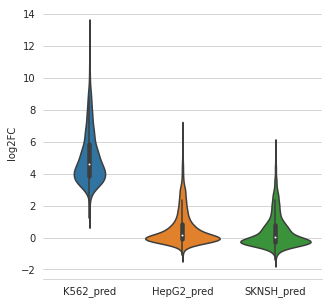

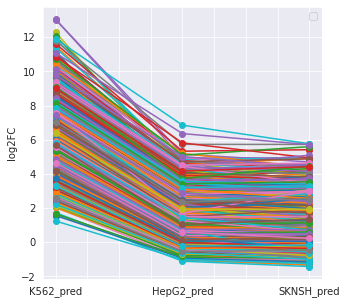

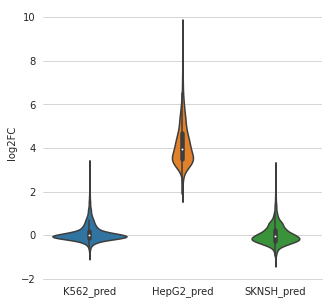

KeyboardInterrupt: 

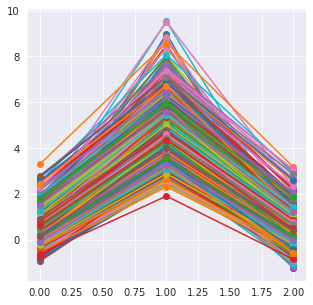

In [40]:
prediction_columns = ['K562_pred', 'HepG2_pred', 'SKNSH_pred']
for out_df in [k562_out_df, hepg2_out_df, sknsh_out_df]:    
    prediction_df = out_df[prediction_columns]
    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(5,5))
        sns.violinplot(data=prediction_df)
        sns.despine(left=True)
        plt.ylabel('log2FC')
        #plt.ylim(-5,32)
        plt.show()
    with sns.axes_style("darkgrid"):
        prediction_df.T.plot(figsize=(5,5), style='-o')
        #plt.ylim(-5,32)
        plt.legend('')
        plt.ylabel('log2FC')
        plt.show()

In [45]:
k562_out_df.to_csv('top_sequences_files/k562_top_genome_df.txt', sep='\t', float_format='%.15f', index=None)
hepg2_out_df.to_csv('top_sequences_files/hepg2_top_genome_df.txt', sep='\t', float_format='%.15f', index=None)
sknsh_out_df.to_csv('top_sequences_files/sknsh_top_genome_df.txt', sep='\t', float_format='%.15f', index=None)

In [46]:
target_dir = 'top_sequences_files/'
cell_names = ['k562', 'hepg2', 'sknsh']
out_dfs = [k562_out_df, hepg2_out_df, sknsh_out_df]

for bias_cell, out_df in enumerate(out_dfs):
    temp_dict = pd.Series(out_df.nt_sequence.values, index=out_df.ID).to_dict()
    user = 'rc'
    cell_name = cell_names[bias_cell]
    generator_name = 'gw'
    track_name = 'track_' + str(0).zfill(3)
    round_name = 'round_' + str(0)
    time_stamp = time.strftime("%Y%m%d_%H%M%S")
    random_tag = str(random.randint(10000000,99999999))
    file_name =  user + '__' + \
                 cell_name + '__' + \
                 generator_name + '__' + \
                 track_name + '__' + \
                 round_name + '__' + \
                 time_stamp + '__' + \
                 random_tag + \
                 '.fa'

    with open(os.path.join(target_dir, file_name), 'w') as ofile:
        for ID, sequence_str in temp_dict.items():
            ofile.write(">" + ID + "\n" + sequence_str + "\n")

In [14]:
for ID, sequence_str in temp_dict.items():
    print(">" + ID + "\n" + sequence_str + "\n")
    #ofile.write(">" + seq_name + "\n" + sequence_str + "\n")

>chr9:134657250-134657450
GGTGCAATTTATAGATAATACAGGGGTGGGGTAGAGGGGTGCAGTTTATAGATAATATGGGGGTGGGGTGTAGGTGTAGTTTATAGATAATATGGGGGCTGGGGTAGGGGGTGAAGTTTATAGATAATATGGGGGTGGGGTGGGGGTGTAGTTTATAGATAATATGGGGGTGGGGTGGGGGTGTAGTTTATAGATAATAT

>chr17:646050-646250
GCCTCTGCCTGATAAGGGTCTTATCTTTTCTAATTCATACCACGGACTGGAGACTGGCTCTTACACACATCTCGGTGACCGCGTGGCCTCTGCCTGATAAGGGTCTTATCTTTTCTAATTCATACCACGGACTGGAGACTGGCTCCCACACACATCTCCGTGACCGTGTGGCCTCTGCCTGATAAGGGTCTTATCTTTTC

>chr17:10477800-10478000
ATAAATGAAAAAGAGAGATAAGACAGGATACAGTAAGTGAACTGGAGTGATAAGACAGGATGCATGTAGTAAATGAGCAGGAAAGATAAGACAGGATGAAATAACTAAATAGGAAAGATAAGACAAGCAGGAGTAACTGGTCAGAAGAGATAAGACAGGATGCAGTAAGTGAAATGGAAAGATAAGATAGGATGCAATAA

>chr19:51546750-51546950
GAAGAACCATGCCTTCAAGGAGAGAGTAATGTAGTGAATTCTTAGAATTGCATGCGACCTCAGTGTCCTTTTGAAATACCAGAAGCGGGGCTCAGTCATCCTTAACAACTTCCAGTTCTAAACCACACTCAAATGGCTCAAGCTGGTGGCCAGAGATAAGAACTTAGACAGGCACAGTGACTCATGCCCTTCAACCAACC

>chr9:134657300-134657500
GATAATATGGGGGTGGGGTGTAGGTGTAGTTTATAGATAATATGGGGGCTGGGGTAGGGGGTGAAGTTT

>chr1:143867700-143867900
GATTATATGCTAAACAAGGGGTGGATTATTATTCCTTTCCAGGAAAGGGGGGGGGCAATTCCAGGAACTGACAGTTCCTCCTCTTTTTAGACCATATAGTGTAATTTCCTGACGTTGCCATGGCACTTGTAAACTGTCATGGTGCTGGTGGGAGTGTCTTTTAACATGCTAATGGATTATAATTAGCATATAATGAGCAG

>chr13:64052550-64052750
GCAGGCTGACTGGAGCTTCTTCAGGGACCCCCTCCTACCTGGCTGTCTCCTTCCCCCATCTAAAGAAGTACATCTAACTGCTCTTAGATTAAGGATAAGGGCCAAGACCTATCTTAGCTGCTTCCTGCTGATAGGGGCTGCTGTTTTGAGGAAACAGCAGTCAGAACTCCCTCAGGGGCCTATCTAAGGGTTCCCAGCAG

>chr9:67134550-67134750
TATGTGGTCTAAAGTGGGGAGGAACCCTCAGTTCTGGGAATTGCCTGCCCCTTTCTTGGAACACTCATGAATAATCCACCCCTTGTTTAGCATATAATAAAGAAATAACTATATTTATCTGAGCAGCCCATGCTGCTGCTCTGCCTCTGGAGTAGCCATTCTTTCATTCCTTTACTTTCTTAATAAACTTGCTTTCACTT

>chr1:74545050-74545250
CCCTATGATAGTTAATTTTATGTGTCAACTTGACTGGACCATGGGATGCCCAGATATGTGGTTAAACATTCTTTCTGGGTGTGTCTGGGTGTTTTCTTAAGAGATTACCATTTGAACCAGTAGACTGAGAAAGGCAGATAGCCCTTCCCAGTGTGAGTAGCATCATCTTATCTATTGAAGGCCTGAATAGAGCAAAAAGG

>chr16:58488700-58488900
GATTGGAACTGTGCAGCCAGCCAGGGATCCAGGGATCCAACCACATGAGGTTGCAGTCCTGCCCCCAG

In [37]:
for sequence in list(k562_out_df['nt_sequence']):
    if 'N' in sequence:
        print(sequence)

In [38]:
for sequence in list(hepg2_out_df['nt_sequence']):
    if 'N' in sequence:
        print(sequence)

In [39]:
count = 0
for sequence in list(sknsh_out_df['nt_sequence']):
    if 'N' in sequence:
        count += 1
        print(sequence)
print(count)

0


In [32]:
sknsh_out_df[~sknsh_out_df['nt_sequence'].str.contains("N")]

,ID,nt_sequence,seq_len,K562_pred,HepG2_pred,SKNSH_pred,OverMaxB_K562,OverMaxB_HepG2,OverMaxB_SKNSH
0,chr15:26417100-26417300,CTATATATAGTTTCTATATATAGTTTCTATATATAGTTTCTATATA...,200,0.533538,0.860539,10.288273,-10.341227,-9.850634,9.850634
1,chr15:26417200-26417400,GTTTCTATATATAGTTTCTATATATAGTTTCTATATATAGTTTCTA...,200,0.620012,0.884815,10.288483,-10.206374,-9.816423,9.816423
2,chr15:26417150-26417350,TTCTATATATAGTTTCTATATATAGTTTCTATATATAGTTTCTATA...,200,0.531651,0.832222,9.986075,-10.042012,-9.588889,9.588889
3,chr15:26417050-26417250,ATATATAGTTTCTATATATAGTTTCTATATATAGTTTCTATATATA...,200,0.485627,0.834727,9.882938,-10.012570,-9.482153,9.482153
4,chr13:104238650-104238850,TAATTTCTTGAAATTAGTCATACTTGAAATACTAGTAATTTCTTGA...,200,0.539402,2.592569,11.994282,-12.037971,-9.476535,9.476535
...,...,...,...,...,...,...,...,...,...
3995,chr10:41880500-41880700,AATGGAATAGAATGTAATGGAATCAACTCGAGTGGAAAGGAATGGA...,200,-0.085752,-0.107128,2.322937,-3.400238,-3.445156,3.400238
3996,chr11:22892900-22893100,AAATTGTGATGTAGCTTATCACTTGTGTAGTCTTACTATAAATGAC...,200,-0.119207,0.243146,2.913359,-4.104875,-3.400077,3.400077
3997,chr20:31065150-31065350,AATGGAATGGAATGGAGTGGAATCAACCACAGTGTAATGGAATGGA...,200,-0.238066,-0.460871,2.025132,-3.400016,-3.939481,3.400016
3998,chr10:38840450-38840650,GAATGCAATGGAATCGAATGGAGTAGACTGGAATGGAATGGACTCG...,200,-0.082128,-0.145243,2.329509,-3.399888,-3.533730,3.399888
